In [1]:
import matplotlib.pyplot as plt
from tools import *

def read_data(path, password):
    _df = crp.read_encrypted(path=path, password=password)
    _df = _df.fillna(0)
    _df /= 100  # change to decimal
    
    _df = _df.apply(lambda x : np.where(x > 1, 0, x))
    _df = _df.apply(lambda x : np.where(x < -1, 0, x))
    
    return _df

path = './public_data/'

file_name = 'release_5083.crypt'  # example: release_3547.crypt
password = 'PEypfZiNg7NA519d' 
df = read_data(path=path + file_name, password=password)

new_file_name = 'release_5083.crypt'
new_password = 'PEypfZiNg7NA519d'



In [2]:
ranks = pd.DataFrame()
data = df[-78:].copy()
ranks['Sortino'] = sortino_ratio(data).sort_values(ascending=False)
ranks['Max Drawdown'] = max_drawdown(data).sort_values(ascending=True)
ranks

,Sortino,Max Drawdown
strat_4,inf,-0.000000
strat_5,inf,-0.000000
strat_12,11.991685,0.050445
strat_19,7.925349,0.108798
strat_7,7.634972,0.100499
strat_31,5.881709,0.079449
strat_40,5.667848,0.096446
strat_45,5.448942,0.079467
strat_36,5.443649,0.047348
strat_42,5.303061,0.016066


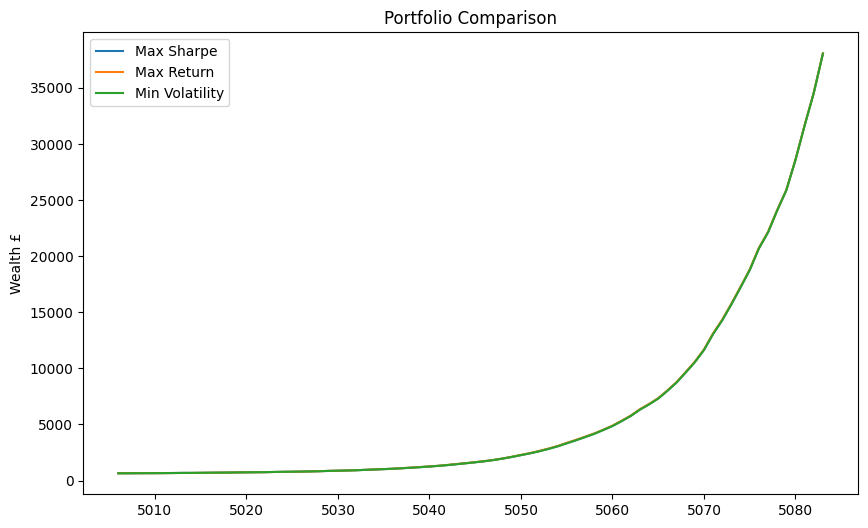

0.63996


strat_0     0.000000
strat_1     0.000000
strat_2     0.000000
strat_3     0.000000
strat_4     0.009990
strat_5     0.009990
strat_6     0.000000
strat_7     0.026872
strat_8     0.012496
strat_9     0.000000
strat_10    0.000000
strat_11    0.000000
strat_12    0.009990
strat_13    0.000000
strat_14    0.000000
strat_15    0.050199
strat_16    0.033758
strat_17    0.056290
strat_18    0.000000
strat_19    0.009990
strat_20    0.000000
strat_21    0.000133
strat_22    0.009700
strat_23    0.000000
strat_24    0.000000
strat_25    0.015362
strat_26    0.013877
strat_27    0.000000
strat_28    0.040168
strat_29    0.000000
strat_30    0.000000
strat_31    0.055246
strat_32    0.049688
strat_33    0.000000
strat_34    0.000000
strat_35    0.043846
strat_36    0.021476
strat_37    0.000000
strat_38    0.001578
strat_39    0.000000
strat_40    0.020571
strat_41    0.000000
strat_42    0.043208
strat_43    0.025984
strat_44    0.029958
strat_45    0.049590
Name: max sharpe ratio, dtype: flo

In [5]:
portfolio_weights = []
portfolio_returns = []
portfolio_risks = []
portfolio_sharpes = []

def compute_portfolio_return(_df, _weights):
    return (1 + np.sum(_weights * _df.mean())) ** 252 - 1

def compute_portfolio_risk(_df, _weights):  # portfolio variance formula
    return np.sqrt(_weights.T @ (_df.cov() * 252) @ _weights)

def compute_random_portfolio(_df, _iterations) -> None:
    ranks = sortino_ratio(_df).sort_values(ascending=False).index[:24] 
    ranks = [int(strat[6:]) for strat in ranks]
    no_of_stocks = _df.shape[1]
    
    rank_4 = ranks[:4] # top 4
    for i in range(_iterations):
        weights = np.zeros(no_of_stocks)
        for n in range(no_of_stocks):
            if n in rank_4 or n not in ranks:
                weights[n] = 0
            else:
                weights[n] = np.random.random()
                
        weights = weights.round(4)
        weights /= abs(weights).sum()
        weights *= 0.6
        
        for n in rank_4:
            weights[n] = 0.00999
        
        portfolio_weights.append(weights)
        
        expected_return = compute_portfolio_return(_df, weights)
        portfolio_returns.append(expected_return)
        
        risk = compute_portfolio_risk(_df, weights)
        portfolio_risks.append(risk)
        
        sharpe = expected_return / risk
        portfolio_sharpes.append(sharpe)
    
data = df[-78:]

# run the simulations
compute_random_portfolio(data, 10_000)

# get the Max Sharpe Ratio, Max Return, Min Volatility
max_sharpe = max(portfolio_sharpes)
max_return = max(portfolio_returns)
min_risk = min(portfolio_risks)

# find the portfolio index for each
sharpe_idx = portfolio_sharpes.index(max_sharpe)
return_idx = portfolio_returns.index(max_return)
min_risk_idx = portfolio_risks.index(min_risk)

# find the portfolio weights for each
sharpe_w = portfolio_weights[sharpe_idx]
max_return_w = portfolio_weights[return_idx]
min_risk_w = portfolio_weights[min_risk_idx]

INITIAL_CASH = 1_000

def compute_wealth(_df, _weights):
    initial_values = (1 + _df.iloc[0]) * _weights * INITIAL_CASH
    cumulative_ret = np.cumprod(1 + _df)
    cumulative_wealths = cumulative_ret * initial_values
    
    return cumulative_wealths.sum(axis=1)


values = pd.DataFrame()
values['Max Sharpe'] = compute_wealth(data, sharpe_w)
values['Max Return'] = compute_wealth(data, max_return_w)
values['Min Volatility'] = compute_wealth(data, min_risk_w)

plt.figure(figsize=(10, 6))
plt.plot(values['Max Sharpe'], label='Max Sharpe')
plt.plot(values['Max Return'], label='Max Return')
plt.plot(values['Min Volatility'], label='Min Volatility')
plt.title('Portfolio Comparison')
plt.ylabel('Wealth £')
plt.legend()
plt.show()

# find the portfolio weights
results_weights = pd.DataFrame(index=data.columns)
results_weights['max sharpe ratio'] = sharpe_w
results_weights['max return'] = max_return_w
results_weights['min risk'] = min_risk_w 

clipped_weights = results_weights['max sharpe ratio']
print(sum(clipped_weights))

clipped_weights

In [6]:
pos_dict = clipped_weights.to_dict()
get_submission_dict(pos_dict)

{'strat_0': 0.0,
 'strat_1': 0.0,
 'strat_2': 0.0,
 'strat_3': 0.0,
 'strat_4': 0.015610350646915435,
 'strat_5': 0.015610350646915435,
 'strat_6': 0.0,
 'strat_7': 0.0419895714113024,
 'strat_8': 0.019526238518986477,
 'strat_9': 0.0,
 'strat_10': 0.0,
 'strat_11': 0.0,
 'strat_12': 0.015610350646915435,
 'strat_13': 0.0,
 'strat_14': 0.0,
 'strat_15': 0.07844036300129525,
 'strat_16': 0.05274985234075316,
 'strat_17': 0.08795872439634439,
 'strat_18': 0.0,
 'strat_19': 0.015610350646915435,
 'strat_20': 0.0,
 'strat_21': 0.00020849744008202828,
 'strat_22': 0.015156857383354405,
 'strat_23': 0.0,
 'strat_24': 0.0,
 'strat_25': 0.02400440092770482,
 'strat_26': 0.021683733768530944,
 'strat_27': 0.0,
 'strat_28': 0.06276679457078105,
 'strat_29': 0.0,
 'strat_30': 0.0,
 'strat_31': 0.08632700530005023,
 'strat_32': 0.07764263366532924,
 'strat_33': 0.0,
 'strat_34': 0.0,
 'strat_35': 0.06851407183217262,
 'strat_36': 0.03355902274711603,
 'strat_37': 0.0,
 'strat_38': 0.00246570885662

In [7]:
df1 = read_data(path + new_file_name, new_password)
pnls = pnl(df1[-78:], clipped_weights)

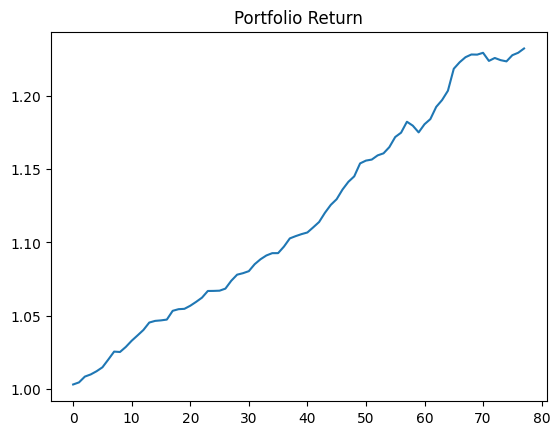

In [8]:
plt.plot(np.cumprod(1 + pnls))
plt.title('Portfolio Return')
plt.show()

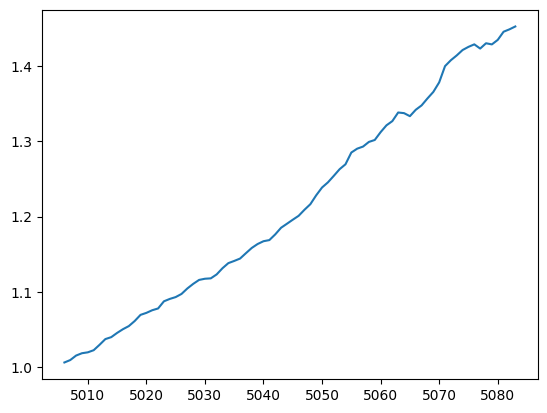

In [9]:
plt.plot(np.cumprod(1 + df1[-78:].mean(axis=1)))
